In [1]:
import os
import json
import gzip
import pandas as pd
import numpy as np
from urllib.request import urlopen

In [4]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz --no-check-certificate

--2023-03-04 22:53:28--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1232323281 (1.1G) [application/x-gzip]
Saving to: ‘Cell_Phones_and_Accessories.json.gz’

Cell_Phones_and_Acc 100%[===================>]   1.15G  23.9MB/s    in 51s     

2023-03-04 22:54:19 (23.1 MB/s) - ‘Cell_Phones_and_Accessories.json.gz’ saved [1232323281/1232323281]



In [5]:
### cargamos la metadata

data = []
with gzip.open('Cell_Phones_and_Accessories.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
# En caso contrario, entonces es windows, por lo que

# largo total de la lista, este numero es igual al numero total de productos
print(len(data))

# primer elemento de la lista
print(data[0])

10063255
{'overall': 5.0, 'verified': False, 'reviewTime': '11 19, 2014', 'reviewerID': 'A1GG51FWU0XQYH', 'asin': '098949232X', 'reviewerName': 'Paul Williams', 'reviewText': 'If your into space this is the Calendar for you.', 'summary': 'Five Stars', 'unixReviewTime': 1416355200}


In [4]:
# Abrimos el json con los productos
data = []
with open('Cell_Phones_and_Accessories.json', 'r') as f:
    for line in f:
        data.append(json.loads(line.strip()))

KeyboardInterrupt: 

In [6]:
# convert list into pandas dataframe

df = pd.DataFrame.from_dict(data)

print(len(df))

10063255


In [7]:
df.head(1000)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5.0,False,"11 19, 2014",A1GG51FWU0XQYH,098949232X,Paul Williams,If your into space this is the Calendar for you.,Five Stars,1416355200,NaN,NaN,NaN
1,5.0,False,"11 19, 2014",AVFIDS9RK38E0,098949232X,Sean Powell,Awesome pictures!,Five Stars,1416355200,NaN,NaN,NaN
2,5.0,False,"11 19, 2014",A2S4AVR5SJ7KMI,098949232X,Tom Davis,Great wall art and information for space explo...,Five Stars,1416355200,NaN,NaN,NaN
3,5.0,False,"11 19, 2014",AEMMMVOR9BFLI,098949232X,Kwajmeck,"As always, it is a quality calendar full of ve...",I love it. I buy a new one every year,1416355200,NaN,NaN,NaN
4,5.0,False,"11 19, 2014",A2DZXMBTY7KLYP,098949232X,ScottG43,This is a fantastic calendar. This is my third...,Great Calendar.,1416355200,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.0,True,"10 25, 2013",A1O7DBN1L02NNE,8288853439,Becky,It works great! My Galaxy S3 charges much fast...,good purchase!,1382659200,3,NaN,NaN
996,5.0,True,"10 11, 2013",A2HA2617RBBNWV,8288853439,kcruser,"Inexpensive, does what it is supposed to do wi...","Good quality, good price, charges beautifully.",1381449600,2,NaN,NaN
997,4.0,True,"10 2, 2013",AXWFX2CUN2XTK,8288853439,Christina SPRAGUE,This charger was for my granddaughter. It arr...,Galaxy Charger,1380672000,NaN,NaN,NaN
998,5.0,True,"10 2, 2013",A9HTZ1Q12IYOS,8288853439,Alex,I don't remember purchasing this charger! Howe...,Not sure,1380672000,NaN,NaN,NaN


In [8]:
# Revisamos si hay valores nulos en la columna reviewText
df['reviewText'].isnull().sum()

# Removemos las filas con valores nulos en la columna reviewText
df = df.dropna(subset=['reviewText'])
print(len(df))

10053882


In [9]:
# Describimos los datos
df.describe()

,overall,unixReviewTime
count,1.005388e+07,1.005388e+07
mean,3.933062e+00,1.440611e+09
std,1.462689e+00,5.204863e+07
min,1.000000e+00,9.413280e+08
25%,3.000000e+00,1.414109e+09
50%,5.000000e+00,1.445731e+09
75%,5.000000e+00,1.475280e+09
max,5.000000e+00,1.538698e+09


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate a CountVectorizer object
vectorizer = CountVectorizer()

# Fit the vectorizer on the text data
vectorizer.fit(df['reviewText'])

# Calculate the size of the vocabulary
vocab_size = len(vectorizer.vocabulary_)

print(f"Vocabulary size: {vocab_size}")


Vocabulary size: 419128


In [11]:
# Revisamos si hay valores nulos o strings en la columna overall
df['overall'].isnull().sum()
df['overall'].dtype

# Convertimos la columna overall a int
df['overall'] = df['overall'].astype(int)


In [12]:
# Distribución de reviews por número de estrellas
rating_counts = df['overall'].value_counts()

print("Distribución de los reviews por rating:")
print(rating_counts)

Distribución de los reviews por rating:
5    5641203
4    1516378
1    1381867
3     860278
2     654156
Name: overall, dtype: int64


### Número de reviews positivas y negativas

Para determinar el número de reseñas positivas y negativas, se puede utilizar la columna 'rating' del conjunto de datos. En general, se considerarán positivas las reseñas con rating de 4 o 5 estrellas, mientras que se considerarán negativas las reseñas con rating de 1 o 2 estrellas. Las reseñas con rating de 3 estrellas se considerarán neutrales y se eliminarán del análisis.

In [13]:
# Filter out reviews with 3-star rating
filtered_data = df[df['overall'] != 3]

# Create a new column 'sentiment' with values 1 for positive reviews and 0 for negative reviews
filtered_data['sentiment'] = filtered_data['overall'].apply(lambda x: 1 if x > 3 else 0)

# Count the number of positive and negative reviews
sentiment_counts = filtered_data['sentiment'].value_counts()

print("Number of positive and negative reviews:")
print(sentiment_counts)

Number of positive and negative reviews:
1    7157581
0    2036023
Name: sentiment, dtype: int64


/tmp/ipykernel_72591/3263270254.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['sentiment'] = filtered_data['overall'].apply(lambda x: 1 if x > 3 else 0)


In [14]:
# Para avanzar más rápido en el análisis, vamos a hacer un muestreo estratificado, tomamos el 25% de los reviews positivos y 25% de los negativos

# Create a new dataframe with 25% of the positive reviews
positive_reviews = filtered_data[filtered_data['sentiment'] == 1].sample(frac=0.002, random_state=42)

# Create a new dataframe with 25% of the negative reviews
negative_reviews = filtered_data[filtered_data['sentiment'] == 0].sample(frac=0.006, random_state=42)

# Concatenate the two dataframes
reduced_filtered_data = pd.concat([positive_reviews, negative_reviews])

# Count the number of positive and negative reviews
sentiment_counts = reduced_filtered_data['sentiment'].value_counts()

print("Number of positive and negative reviews:")
print(sentiment_counts)

# Lo guardamos en un archivo csv
reduced_filtered_data.to_csv('amazon_reviews_reduced.csv', index=False)



Number of positive and negative reviews:
1    14315
0    12216
Name: sentiment, dtype: int64


In [15]:
# Cargamos el archivo csv
# reduced_filtered_data = pd.read_csv('amazon_reviews_reduced.csv')

### N-grams mas frecuentes

In [17]:
# Instantiate a CountVectorizer object with ngram_range=(1,2) to extract unigrams and bigrams
vectorizer = CountVectorizer(ngram_range=(1,2))

# Fit the vectorizer on the text data
vectorizer.fit(reduced_filtered_data['reviewText'])

# Transform the text data into a sparse matrix of features
X = vectorizer.transform(reduced_filtered_data['reviewText'])

# Sum the occurrences of each feature across all reviews
ngram_counts = X.sum(axis=0)

# Convert the sparse matrix to a numpy array and flatten it
ngram_counts_array = np.squeeze(np.asarray(ngram_counts))

# Get the indices that sort the array in descending order
sorted_indices = np.argsort(ngram_counts_array)[::-1]

# Get the 20 most frequent unigrams and bigrams
top_ngrams = [(vectorizer.get_feature_names_out()[i], ngram_counts_array[i]) for i in sorted_indices[:20]]

print("Top 20 most frequent unigrams and bigrams:")
print(top_ngrams)

Top 20 most frequent unigrams and bigrams:
[('the', 54787), ('it', 36939), ('and', 27685), ('to', 24155), ('is', 15986), ('this', 15918), ('my', 15036), ('phone', 14225), ('for', 12807), ('of', 12560), ('case', 12470), ('not', 10850), ('on', 10264), ('in', 9686), ('that', 9153), ('was', 8817), ('but', 8459), ('with', 8315), ('have', 6664), ('you', 6545)]


### Nubes de palabras

Para visualizar las palabras más frecuentes en el conjunto de datos, se puede utilizar una nube de palabras. Se puede utilizar la librería wordcloud para crear una nube de palabras.

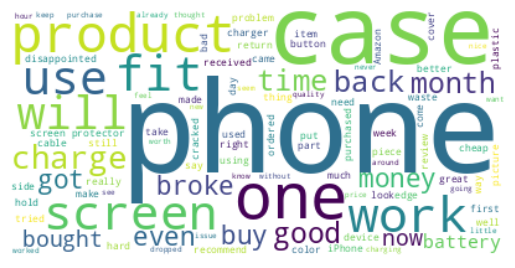

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all negative reviews into a single string
negative_reviews = reduced_filtered_data[reduced_filtered_data['sentiment'] == 0]['reviewText'].str.cat(sep=' ')

# Create a WordCloud object with max_words=100 and background_color='white'
wordcloud = WordCloud(max_words=100, background_color='white').generate(negative_reviews)

# Plot the WordCloud object using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

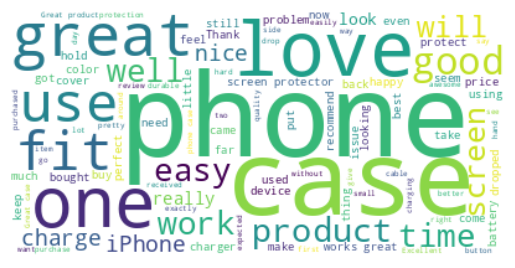

In [21]:
# Lo hacemos ahora con los reviews positivos
# Combine all positive reviews into a single string
positive_reviews = reduced_filtered_data[reduced_filtered_data['sentiment'] == 1]['reviewText'].str.cat(sep=' ')

# Create a WordCloud object with max_words=100 and background_color='white'
wordcloud = WordCloud(max_words=100, background_color='white').generate(positive_reviews)

# Plot the WordCloud object using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec

Para visualizar los embeddings de palabras en un espacio de 2 dimensiones, se puede utilizar una técnica de reducción de dimensionalidad como PCA o t-SNE. En este caso, se utilizará t-SNE.

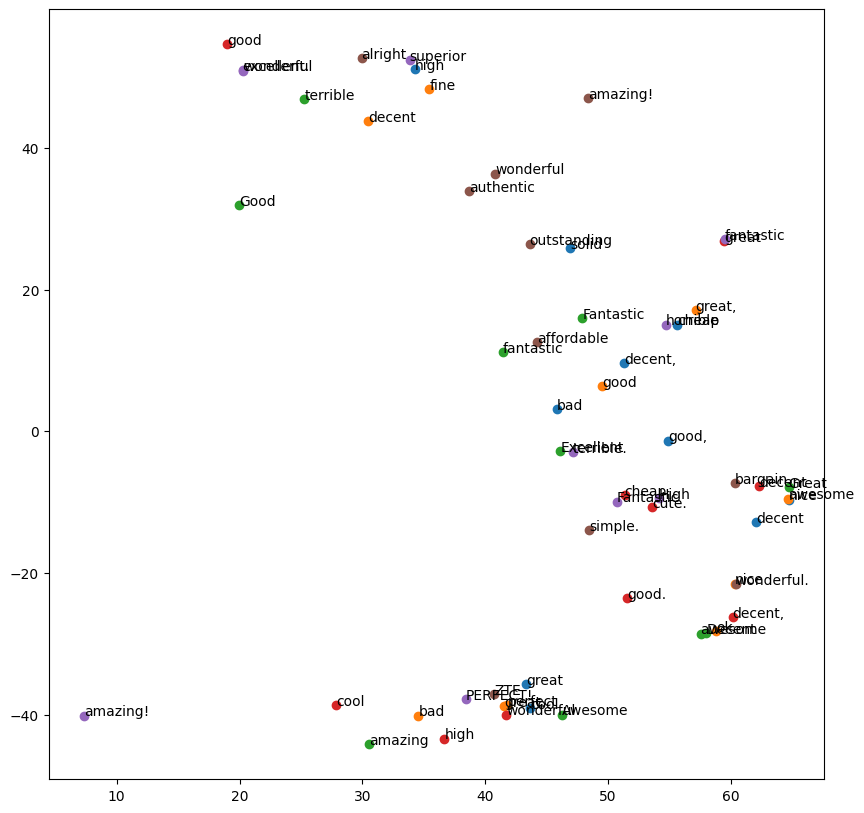

In [25]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

# Train a Word2Vec model on the text data
sentences = [review.split() for review in reduced_filtered_data['reviewText']]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Get the top 10 most similar words for each of the input words
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=10)]
                 for search_term in ['good', 'great', 'excellent', 'bad', 'terrible', 'awful']}
# input_words = ['good', 'bad', 'love', 'hate', 'cheap']
# similar_words = {word: [similar_word[0] for similar_word in model.wv.most_similar(word, topn=10)] for word in input_words}

# Convert the word embeddings to a 2D array using t-SNE
tsne = TSNE(n_components=2, random_state=0)
word_vectors_2d = tsne.fit_transform(model.wv.vectors)


# Plot the word embeddings in 2D
plt.figure(figsize=(10, 10))
for i, word in enumerate(similar_words.keys()):
    x = word_vectors_2d[i*10:(i+1)*10, 0]
    y = word_vectors_2d[i*10:(i+1)*10, 1]
    plt.scatter(x, y)
    for j, similar_word in enumerate(similar_words[word]):
        plt.annotate(similar_word, xy=(x[j], y[j]))
plt.show()


Este código entrenará un modelo Word2Vec en el conjunto de datos y visualizará los embeddings de palabras en 2 dimensiones utilizando t-SNE. Se han seleccionado 5 palabras de entrada ('good', 'bad', 'love', 'hate', 'cheap') y se han mostrado las 10 palabras más similares a cada una de ellas.

### Conclusiones de la exploración

En esta etapa se ha realizado un análisis exploratorio de los datos del conjunto de reseñas de Amazon. Se ha calculado la cardinalidad del vocabulario, se ha analizado la distribución de las reseñas por número de estrellas, se ha determinado el número de reseñas positivas y negativas, se han encontrado los N-grams más frecuentes, se ha creado una nube de palabras y se han visualizado algunos embeddings de palabras en 2 dimensiones.

A partir de estos análisis, se pueden obtener algunas conclusiones preliminares sobre el conjunto de datos. Por ejemplo, se ha encontrado que el tamaño del vocabulario es bastante grande, lo que sugiere que el conjunto de datos es bastante diverso en términos de vocabulario. También se ha encontrado que hay una mayor cantidad de reseñas positivas que negativas, lo que sugiere que el conjunto de datos puede estar desbalanceado.

## Preprocesado

En esta etapa, se realizará el preprocesado de las reseñas de Amazon para adecuar el formato de las mismas a uno más adecuado para su procesamiento posterior.

### Limpieza de texto

En primer lugar, se realizará una limpieza básica de las reseñas de Amazon para eliminar caracteres no alfabéticos y convertir el texto a minúsculas.

In [29]:
import re
import string

def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Copy the dataframe in a new one
data_lower = reduced_filtered_data.copy()

# Apply the clean_text function to the 'review' column of the dataset
data_lower['reviewText'] = data_lower['reviewText'].apply(clean_text)

In [31]:
# Guardamos este dataset en un fichero csv
data_lower.to_csv('data_lower_preprocesado.csv', index=False)
